# Data analysis of the glacier model

In [1]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load('../data/vary_beta.dat.npz')
print(list(data.keys()))


['inputs', 'uout', 'jrav']


In [2]:
inputs = data['inputs']
uout = data['uout']
jrav = data['jrav']

# print('input shape ', inputs.shape)
# print('output shape', uout.shape)
# print('adjoint shape', jrav.shape)

# # check which 79 variables are the physical model parameters instead of the solutions
# # the last 79 variables are model parameters
# # in the adjoint matching training, just focus on those.
# plt.imshow(inputs, aspect='auto')
# plt.show()

import pandas as pd
df = pd.DataFrame(inputs)
df.describe()


,0,1,2,3,4,5,6,7,8,9,...,149,150,151,152,153,154,155,156,157,158
count,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04
mean,0.0,4.377111,8.755940,13.138207,17.525642,21.919985,26.322992,30.736436,35.162116,39.601856,...,0.000370,0.000201,0.000107,0.000056,0.000029,0.000014,0.000007,0.000003,0.000002,7.438788e-07
std,0.0,4.066441,8.133370,12.201276,16.270651,20.341986,24.415778,28.492527,32.572739,36.656925,...,2.901366,2.901366,2.901366,2.901366,2.901366,2.901366,2.901366,2.901366,2.901366,2.901366e+00
min,0.0,0.461533,0.923447,1.386124,1.849947,2.315304,2.782584,3.252184,3.724504,4.199952,...,-4.999630,-4.999799,-4.999893,-4.999944,-4.999971,-4.999986,-4.999993,-4.999997,-4.999998,-4.999999e+00
25%,0.0,1.142697,2.286074,3.430815,4.577604,5.727129,6.880083,8.037167,9.199087,10.366558,...,-2.499630,-2.499799,-2.499893,-2.499944,-2.499971,-2.499986,-2.499993,-2.499997,-2.499998,-2.499999e+00
50%,0.0,2.548837,5.098608,7.650246,10.204689,12.762876,15.325752,17.894264,20.469368,23.052028,...,0.000370,0.000201,0.000107,0.000056,0.000029,0.000014,0.000007,0.000003,0.000002,7.438788e-07
75%,0.0,6.813698,13.632463,20.461374,27.305532,34.170071,41.060174,47.981076,54.938085,61.936587,...,2.500370,2.500201,2.500107,2.500056,2.500029,2.500014,2.500007,2.500003,2.500002,2.500001e+00
max,0.0,13.437452,26.876306,40.317963,53.763828,67.215303,80.673795,94.140712,107.617462,121.105457,...,5.000370,5.000201,5.000107,5.000056,5.000029,5.000014,5.000007,5.000003,5.000002,5.000001e+00


In [3]:
inputs.std(axis=0)[-3:]
from utils.plotter import Plotter

plotter = Plotter()

print(uout.min(), uout.max())
print(inputs.min(), inputs.max())
print(jrav.min(), jrav.max())




0.0 1773.939748633615
-4.999999256121194 1773.939748633615
-36.37509660888256 55.04949626260833


In [4]:

import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
a = jnp.asarray(jrav, dtype=jnp.float64)
jnp.mean(a)

Array(-0.00852645, dtype=float64)

# Find out the most sensitive 5 parameters to match
Since the performance of adjoint matching NN is suboptimal for either all parameters including states or parameters only, we can start with simpler situtaitons.

We use $L_2$ norm of each **row** of the Jacobian to determine the most sensitive input parameters. 

In [7]:
# Find out the most sensitive parameters: top 5
from numpy.linalg import norm
norms = norm(jrav, axis=1)
normsMean = np.mean(norms, axis=0)
maxIdx = np.argsort(normsMean)[:5]
print('The most senstivie 5 parameters are', maxIdx)
# returns the last few states!

The most senstivie 5 parameters are [78 79 77 76 75]


dict_keys(['train_loss', 'train_adj_loss', 'val_loss', 'val_adj_loss', 'train_r2', 'val_r2', 'best_params', 'final_params'])


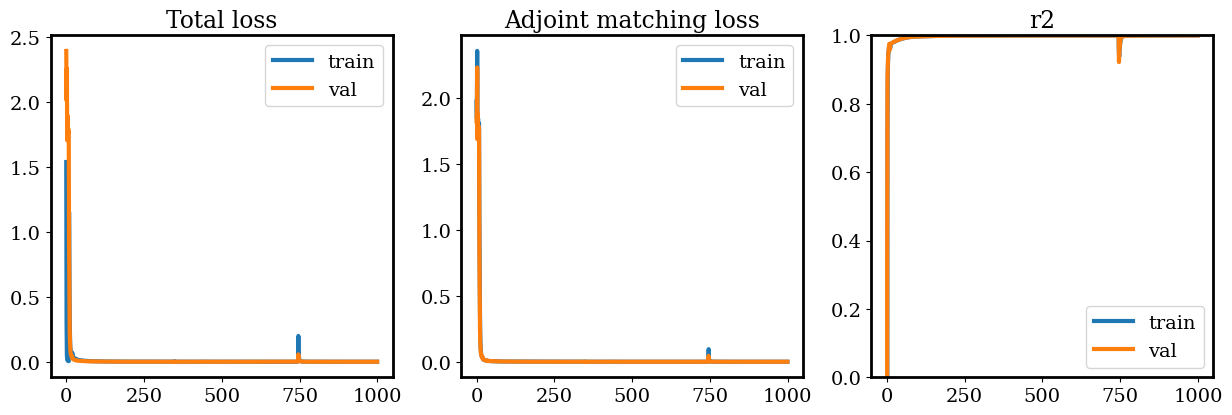

In [9]:
import matplotlib.pyplot as plt
import pickle

with open('./logs/logger_04-11-14_BurgersVJP_lr0.0001_alpha1', 'rb') as f:
    logger = pickle.load(f)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
print(logger.keys())

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot(logger['train_loss'], label='train')
ax[0].plot(logger['val_loss'], label='val')
# ax[0].set_ylim(0, 1000)
ax[1].plot(logger['train_adj_loss'], label='train')
ax[1].plot(logger['val_adj_loss'], label='val')
ax[2].plot(logger['train_r2'], label='train')
ax[2].plot(logger['val_r2'], label='val')
ax[2].set_ylim(0,1)
ax[0].set_title('Total loss')
ax[1].set_title('Adjoint matching loss')
ax[2].set_title('r2')
for a in ax:
    a.legend()
    a.set_box_aspect(1)
# fig.savefig('./figs_adjoint/trainingCurve_mixed_nu.pdf', format='pdf')
plt.show()

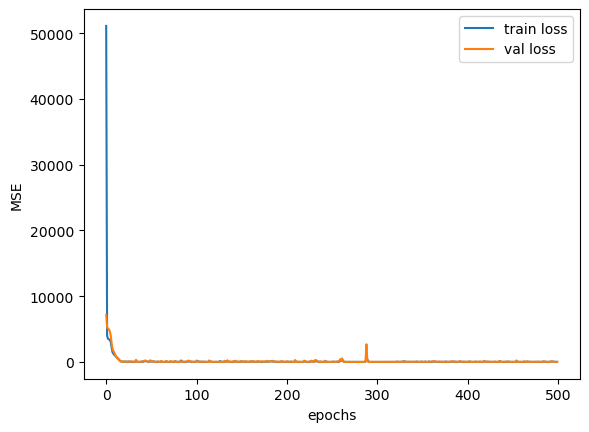

In [9]:
fig, ax = plt.subplots()
ax.plot(logger['train_loss'], label='train loss')
ax.plot(logger['val_loss'], label='val loss')
ax.set_xlabel('epochs')
ax.set_ylabel('MSE')
# ax.set_ylim(-5, 200)
plt.legend()


In [19]:
from AdjointMatchJAX import MLP, Trainer
from utils.data_loader import split_data
from utils.metrics import mean_squared_error, r2
from utils.scaler import StandardScaler
import pickle
import optax
import numpy as np

# config.update("jax_enable_x64", True)

data = np.load('../data/vary_beta.dat.npz')
inputs = data['inputs']
uout = data['uout']
jrav = data['jrav']

with open('./logs/logger_04-06-10_mostSensFive_Standardized_lr0.0005_alpha10.0', 'rb') as f:
    logger = pickle.load(f)



train, val, test = split_data(inputs, uout, jrav, shuffle_all=True)
scaler = StandardScaler(train['x'])
x = test['x']
net = MLP([256]*10, in_dim=159, out_dim=80, act_fn='relu', scaler=scaler)

params = logger['best_params']
test_pred = net.apply(params, x)
# test_pred = y_scaler.inverse_transform(test_pred)
pred_adj = net.nn_adjoint(params, inputs)
# pred_adj = adj_scaler.inverse_transform(pred_adj)

u_pred = net.apply(params, inputs)
# u_pred = y_scaler.inverse_transform(u_pred)


print('The test MSE is {:.4f}'.format(mean_squared_error(test['y'], test_pred)))
# print('The train MSE is {:.4f}'.format(mean_squared_error(train['y'], u_pred)))
print('The test R2 is {:.4f}'.format(r2(test['y'], test_pred)))
print('The test adj mse is {:.4f}'.format(mean_squared_error(jrav[...,75:80], pred_adj[..., 75:80])))
print('The test adj R2 is {:4f}'.format(r2(jrav[..., 75:80], pred_adj[..., 75:80])))





The test MSE is 0.2946
The test R2 is 1.0000
The test adj mse is 0.0001
The test adj R2 is -3899850297111193.000000


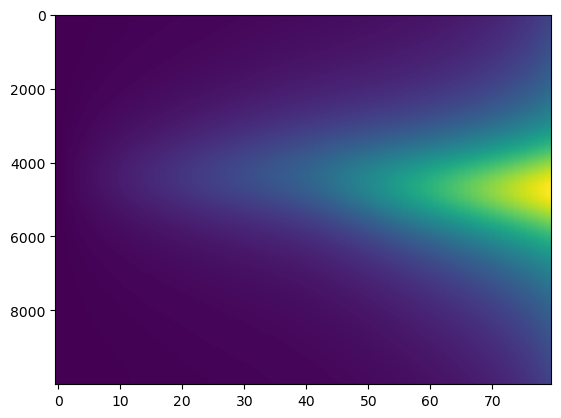

In [20]:
from utils.plotter import Plotter

plotter = Plotter()
# print(uout.shape)
# plotter.heat_map(uout[-5000:],test_pred)
plt.imshow(u_pred, aspect='auto')

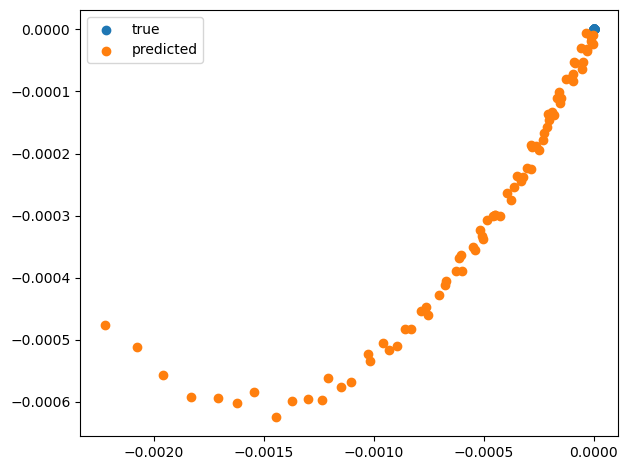

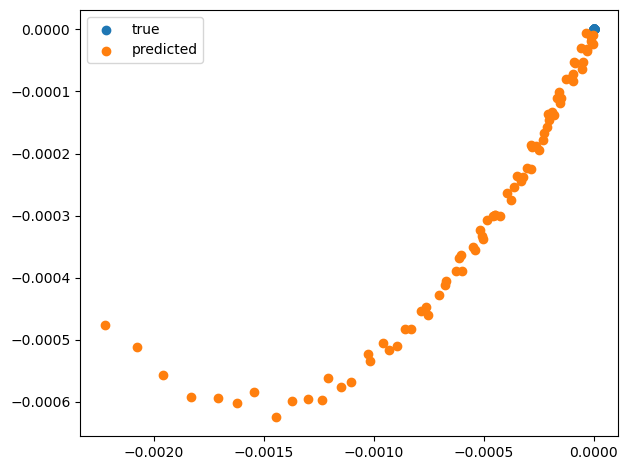

In [21]:
plotter.pca_plot(test['adj'][..., 75:80][3], pred_adj[..., 75:80][3])